## Generate geoJSON files for contours of inundation map

## References

1. [Extracting contours](https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour)
2. [Python Path objects](https://matplotlib.org/api/path_api.html)
3. [Geojson package](https://pypi.org/project/geojson/)
4. [Python Path tutorial](https://matplotlib.org/users/path_tutorial.html)
5. [Shapely package](https://pypi.org/project/Shapely/)

### First import some necessary tools
Note: you'll need to install the geojson module to run this notebook. If you have pip you can simply run
>pip install geojson

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from __future__ import print_function
from ptha_paths import data_dir, events_dir
import sys, os
from matplotlib import _cntr as cntr
from geojson import MultiPolygon, Feature, FeatureCollection, dump
from skimage import measure
import geojson

Assuming that top level of this repository is at: /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial
    Python codes can be found in codes_dir = /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial/PythonCode
    Data files can be found in data_dir = /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial/DataFiles
    Results for each event can be found in events_dir = /Users/aengle/Desktop/tsunami-inundation/ptha_tutorial/DataFiles/Events


### Set parameters 

In [7]:
# Parameters
events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']     # The events to consider
sch = ['SChSZa']
num_levels = 5      # The number of levels to partition inundation into

In [8]:
zeta_level_values

[0.01, 0.5, 7.0, 13.5, 20.0]

### Read in the topography data and compute zeta-clines

In [9]:
# Read in topography data:
nx = 250
ny = 250

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0] - 360   # Longitudes
y=d[:,1]         # Latitudes
B=d[:,2]         # Bathymetry (topography in the absence of water)
topo = reshape(B, (nx,ny), order='F')
X = reshape(x, (nx,ny), order='F')  # X[0,0] is min long, X[-1, 0] is max long
Y = reshape(y, (nx,ny), order='F')  # Y[0,0] is min lat,  Y[0, -1] is max lat

In [10]:
# Loop over all events and compute zeta clines for each
# Collect zeta clines for each level in multi-polygon environments
# for event in events:
for event in sch:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    
    features = [None] * num_levels
    c = cntr.Cntr(X,Y,Hmax)
    path_list = []
    for k in xrange(num_levels):
        # Go from largest values to smallest to get appropriate overlapping
        # contours = c.trace(zeta_level_values[num_levels-k-1])  # this returns paths and categorical variables. Separate..
        contours = c.trace(zeta_level_values[num_levels-k-1])  # this returns paths and categorical variables. Separate..
        num_paths = len(contours) // 2   # Half of the entries correspond to path connection types
        path_list = [poly.tolist() for poly in contours[:num_paths]]  # grab the first half
        multi_poly = MultiPolygon([path_list])
        features[num_levels-k-1] = Feature(geometry=multi_poly)
    # features = Feature(geometry=multi_poly)
    feature_collection = FeatureCollection(features)
    json_file = os.path.join(event_dir, 'contours.geojson')
    
    # Write to a file using geojson dump in the events dir (see first cell of this notebook)
    #with open(json_file, 'w') as outfile:
    #    dump(feature_collection, outfile)
    

# The next cell is an example of the Shapely package.

In [11]:
from shapely.geometry import polygon
for i in range(len(cs.collections)):
    p = cs.collections[i].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    poly = Polygon([(j[0], j[1]) for j in zip(x,y)])
    print(i, poly)

NameError: name 'cs' is not defined

# This cell will generate the separate contour regions for the number of contour levels specified above. 

[0.0, 0.61779757499999999, 1.23559515, 1.853392725, 2.4711903]
[0.0, 1.4123239999999999, 2.8246479999999998, 4.2369719999999997, 5.6492959999999997]
[0.0, 0.60893924999999993, 1.2178784999999999, 1.8268177499999998, 2.4357569999999997]
[0.0, 0.13777397499999999, 0.27554794999999999, 0.41332192499999998, 0.55109589999999997]
[0.0, 4.0317651000000003, 8.0635302000000006, 12.0952953, 16.127060400000001]
[0.0, 3.44519895, 6.8903979, 10.33559685, 13.7807958]
[0.0, 2.2350222049999999, 4.4700444099999999, 6.7050666149999998, 8.9400888199999997]
[0.0, 1.5686154000000001, 3.1372308000000002, 4.7058461999999999, 6.2744616000000004]
[0.0, 1.1475101250000002, 2.2950202500000003, 3.4425303750000005, 4.5900405000000006]
[0.0, 0.79291739999999999, 1.5858348, 2.3787522000000001, 3.1716696]
[0.0, 0.37679597999999997, 0.75359195999999995, 1.1303879399999999, 1.5071839199999999]
[0.0, 0.10593104999999992, 0.21186209999999983, 0.31779314999999975, 0.42372419999999966]
[0.0, 0.57716180500000003, 1.15432361

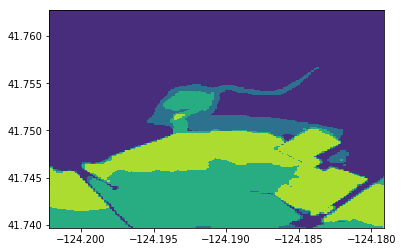

In [18]:
# Shapely does not play well with the geoJSON package, so I will use some string methods from Python
# Based off https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects
from shapely import geometry
import string
table = string.maketrans('()','[]')
table2 = string.maketrans('\'', '\"')
feature_collection = [None]*num_levels
for event in events:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    #mylevels = arange(0,16,.5);
    mylevels = list(linspace(np.min(Hmax),np.max(Hmax),num_levels));
    print(mylevels);
    cs = plt.contourf(X, Y, Hmax, mylevels)
    # First, loop through all zeta-levels
    feats = []
    #print(len(cs.collections))
    for kk in range(len(cs.collections)):
        col = cs.collections[kk];
        # feats = []  # feats is the payload to the "features" in geoJSON
        # Second, loop through all polygons that have the same zeta-level
        for contour_path in col.get_paths(): 
            # Create the polygons for this intensity level
            # The first polygon in iteration is the main polygon, the following ones are "holes"
            # Third, iterate through all sub-polygons that make up the main polygon
            for ncp,cp in enumerate(contour_path.to_polygons()):
                x = cp[:,0]
                y = cp[:,1]
                # new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
                new_shape = geometry.LinearRing([(i[0], i[1]) for i in zip(x,y)])
                if ncp == 0:
                    first = [(i[0], i[1]) for i in zip(x,y)]
                    # poly = [new_shape]  # need to delete the holes in this inner-loop. This can be done by merging the polygons,
                    last = []
                else:
                    last.append([(i[0], i[1]) for i in zip(x,y)])
                    # poly = poly.append(new_shape)
                # instead of making a new polygon
            # print(poly[1])
            polyjson = {"geometry": geometry.mapping(geometry.Polygon(first, last)), "type": "Feature", "levelSetValue": mylevels[kk]}  # prep the payload
            feats.append(polyjson)
    json_file = os.path.join(event_dir, 'contours.geojson')

    # Write to a file in the events dir (see first cell of this notebook)
    with open(json_file, 'w') as outfile:
        outfile.write(str({"type": "FeatureCollection", "features": feats}).translate(table).translate(table2))
    # print(str({"type": "FeatureCollection", "features": feats}).translate(table).translate(table2))

#### Everything below is experiments with contour plots in matplotlib.

In [ ]:
from matplotlib import contour

In [ ]:
plt.contourf(X,Y,Hmax, zeta_level_values)

In [ ]:
## example see this link:
# https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour
xx = np.linspace(-1,1,nx)
XX = np.repeat(xx, nx).reshape(nx,ny)
YY = np.tile(xx, nx).reshape(nx,ny)
ZZ = XX**2 + YY**2
c = cntr.Cntr(XX, YY, ZZ)
contours = c.trace(0.5)  # the ZZ = 0.5 level-curve
num_paths = len(contours) // 2  # see this stackexchange link

In [ ]:
plt.contourf(XX,YY,ZZ,levels=[0,0.5,1,1.5,1.75])